In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("cardio_train.csv", sep=';')
%matplotlib inline     
sns.set(color_codes=True)

### Cleaning the data

In [32]:
# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]
# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

In [33]:
# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

### Making the hypertention group

In [34]:
# bin blood pressure groups based on the api hi/ lo variables
df['bp'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, 0)
df['bp'] = np.where((df.ap_hi >= 120) & (df.ap_hi < 130) & (df.ap_lo < 80), 2, df.bp)
df['bp'] = np.where((df.ap_hi >= 130) & (df.ap_hi < 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 3, df.bp)
df['bp'] = np.where((df.ap_hi >= 140) | (df.ap_lo >= 90), 4, df.bp)
df['bp'] = np.where((df.ap_hi > 180) | (df.ap_lo > 120), 5, df.bp)
df['bp1'] = pd.cut(df.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


### Making the BMI group

In [35]:
# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2

# create BMI group categorical bins
df['bmiGrp'] = np.where((df.bmi < 18.5), 1, 0)
df['bmiGrp'] = np.where((df.bmi >= 18.5) & (df.bmi < 25), 2, df.bmiGrp)
df['bmiGrp'] = np.where((df.bmi >= 25) & (df.bmi < 30), 3, df.bmiGrp)
df['bmiGrp'] = np.where((df.bmi >= 30), 4, df.bmiGrp)
df['bmiGrp1'] = pd.cut(df.bmiGrp,[0,1,2,3,4],4,labels=['Under Weight','Normal Weight','Over Weight','Obese' ]) # this creates a new variable


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53053 entries, 1 to 69999
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           53053 non-null  int64   
 1   age          53053 non-null  int64   
 2   gender       53053 non-null  int64   
 3   height       53053 non-null  int64   
 4   weight       53053 non-null  float64 
 5   ap_hi        53053 non-null  int64   
 6   ap_lo        53053 non-null  int64   
 7   cholesterol  53053 non-null  int64   
 8   gluc         53053 non-null  int64   
 9   smoke        53053 non-null  int64   
 10  alco         53053 non-null  int64   
 11  active       53053 non-null  int64   
 12  cardio       53053 non-null  int64   
 13  bp           53053 non-null  int64   
 14  bp1          53053 non-null  category
 15  bmi          53053 non-null  float64 
 16  bmiGrp       53053 non-null  int64   
 17  bmiGrp1      53053 non-null  category
dtypes: category(2), float64(2)

In [37]:
# 5. Rearrange the columns that are important for the analysis as per domein knowledge and EDA
df_f = df[['cholesterol','gluc','bp','gender','bmi','age', 'cardio']]

df_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53053 entries, 1 to 69999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cholesterol  53053 non-null  int64  
 1   gluc         53053 non-null  int64  
 2   bp           53053 non-null  int64  
 3   gender       53053 non-null  int64  
 4   bmi          53053 non-null  float64
 5   age          53053 non-null  int64  
 6   cardio       53053 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 3.2 MB


### Training and testing split

In [38]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'cardio' in df_f:
    y = df_f['cardio'].values # get the labels we want
    del df_f['cardio'] # get rid of the class label
    X = df_f.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Logistic Regression

In [39]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
accuracy 0.6402789558005842
confusion matrix
 [[2114 2414]
 [1403 4680]]
====Iteration 1  ====
accuracy 0.6298181132786731
confusion matrix
 [[2160 2437]
 [1491 4523]]
====Iteration 2  ====
accuracy 0.5941947036094619
confusion matrix
 [[1534 3192]
 [1114 4771]]


### Interpretation of the weight

In [40]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_f.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

cholesterol has weight of 0.38109218697775626
gluc has weight of 0.009165480729398533
bp has weight of 0.5203590684612173
gender has weight of -0.17727048764800543
bmi has weight of -0.020479800902919027
age has weight of -5.376988574039279e-05


### Normalize weight

In [41]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_f.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.7079445858071812
[[3247 1479]
 [1620 4265]]
gluc has weight of -0.07975139441389137
gender has weight of -0.010044497172826669
bmi has weight of 0.15051113776752162
age has weight of 0.32337699152121485
cholesterol has weight of 0.3442424869239958
bp has weight of 0.7711165016604355


### Graph the weight

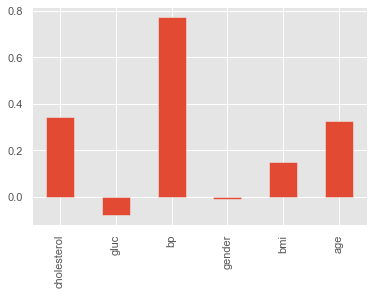

In [42]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df_f.columns)
weights.plot(kind='bar')
plt.show()

### Analysis of colinearity(but does not work)

In [43]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

Xnew = df_f[['age','bmi','gender', 'bp', 'gluc', 'cholesterol']].values

weights = []
# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    piped_object.fit(Xnew[train_indices],y[train_indices])  # train object
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
weights = np.array(weights)

import plotly

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ['age','bmi','gender', 'bp', 'gluc', 'cholesterol'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

### Support Vector Machine

In [44]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.7128451606823109
[[3378 1348]
 [1699 4186]]


In [45]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(26286, 6)
(26286,)
[12432 13854]


### Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors (but it does not work  Length of values (26300) does not match length of index (53053)) need to be investigated

In [46]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df_f.iloc[train_indices].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_f['cardio'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df_f['cardio'] = y # also add it back in for the original data
df_support.info()

ValueError: Length of values (26286) does not match length of index (53053)

###  Use some compact notation for creating a linear SVM classifier with stichastic descent

In [47]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit 

cv = StratifiedShuffleSplit( n_splits=1,test_size=0.5)

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM:', acc)

SVM: 0.7073170731707317


### Use some compact notation for creating a logistic regression classifier with stochastic descent

In [48]:
log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.7081087194179515
